In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import kagglehub
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)

100%|██████████| 242M/242M [00:02<00:00, 97.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [ ]:
import os
import kagglehub
import pandas as pd
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)
filepath = os.path.join(path, 'Reviews.csv')
df = pd.read_csv(filepath)
df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

In [ ]:
#info about all the columns of data
df.dtypes

,0
Id,int64
ProductId,object
UserId,object
ProfileName,object
HelpfulnessNumerator,int64
HelpfulnessDenominator,int64
Score,int64
Time,int64
Summary,object
Text,object


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 10000):
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
corpus=pd.DataFrame(corpus, columns=['Reviews'])
corpus.head()

,Reviews
0,bought sever vital can dog food product found ...
1,product arriv label jumbo salt peanut peanut a...
2,confect around centuri light pillowi citru gel...
3,look secret ingredi robitussin believ found go...
4,great taffi great price wide assort yummi taff...


In [ ]:
result=corpus.join(df[['Score']])
result.head()

,Reviews,Score
0,bought sever vital can dog food product found ...,5
1,product arriv label jumbo salt peanut peanut a...,1
2,confect around centuri light pillowi citru gel...,4
3,look secret ingredi robitussin believ found go...,2
4,great taffi great price wide assort yummi taff...,5


**Find The Term's Frequency (TF) and Inverse Document Frequency (IDF).**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(result['Reviews'])

TfidfVectorizer()

In [ ]:
X = tfidf.transform(result['Reviews'])
result['Reviews'][1]

'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo'

In [ ]:
print([X[1, tfidf.vocabulary_['peanut']]])

[0.37509695630835344]


In [ ]:
print([X[1, tfidf.vocabulary_['jumbo']]])

[0.5727828521365452]


In [ ]:
print([X[1, tfidf.vocabulary_['error']]])

[0.27060037347083044]


**Sentiment Classification**

In [ ]:
result.dropna(inplace=True)
result[result['Score'] != 3]
result['Positivity'] = np.where(result['Score'] > 3, 1, 0)
cols = [ 'Score']
result.drop(cols, axis=1, inplace=True)
result.head()

,Reviews,Positivity
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


In [ ]:
result.groupby('Positivity').size()

,0
Positivity,
0,2384
1,7616



**Splitting the Data : Train-test**

In [ ]:
from sklearn.model_selection import train_test_split
X = result.Reviews
y = result.Positivity
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train set has total 7500 entries with 23.57% negative, 76.43% positive


In [ ]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))


Test set has total 2500 entries with 24.64% negative, 75.36% positive


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [ ]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [ ]:
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 5))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(class_weight='balanced')


Test result for 10000 features
accuracy score: 84.40%
Test result for 15000 features
accuracy score: 83.40%
Test result for 20000 features
accuracy score: 83.12%
Test result for 25000 features
accuracy score: 83.36%
Test result for 30000 features
accuracy score: 83.08%


In [ ]:
from sklearn.metrics import classification_report

cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
print("The accuracy score for CV as vectorizer" + str(accuracy_score( y_test, y_pred)))

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

The accuracy score for CV as vectorizer0.8304
              precision    recall  f1-score   support

    negative       0.91      0.35      0.50       616
    positive       0.82      0.99      0.90      1884

    accuracy                           0.83      2500
   macro avg       0.87      0.67      0.70      2500
weighted avg       0.84      0.83      0.80      2500



In [ ]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = pipeline, X= X_train, y = y_train,
                             cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))


Random Forest Classifier Accuracy: 0.84 (+/- 0.02)


**Chi2 feature selection**

In [ ]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(result.Reviews)
y = result.Positivity
chi2score = chi2(X_tfidf, y)[0]


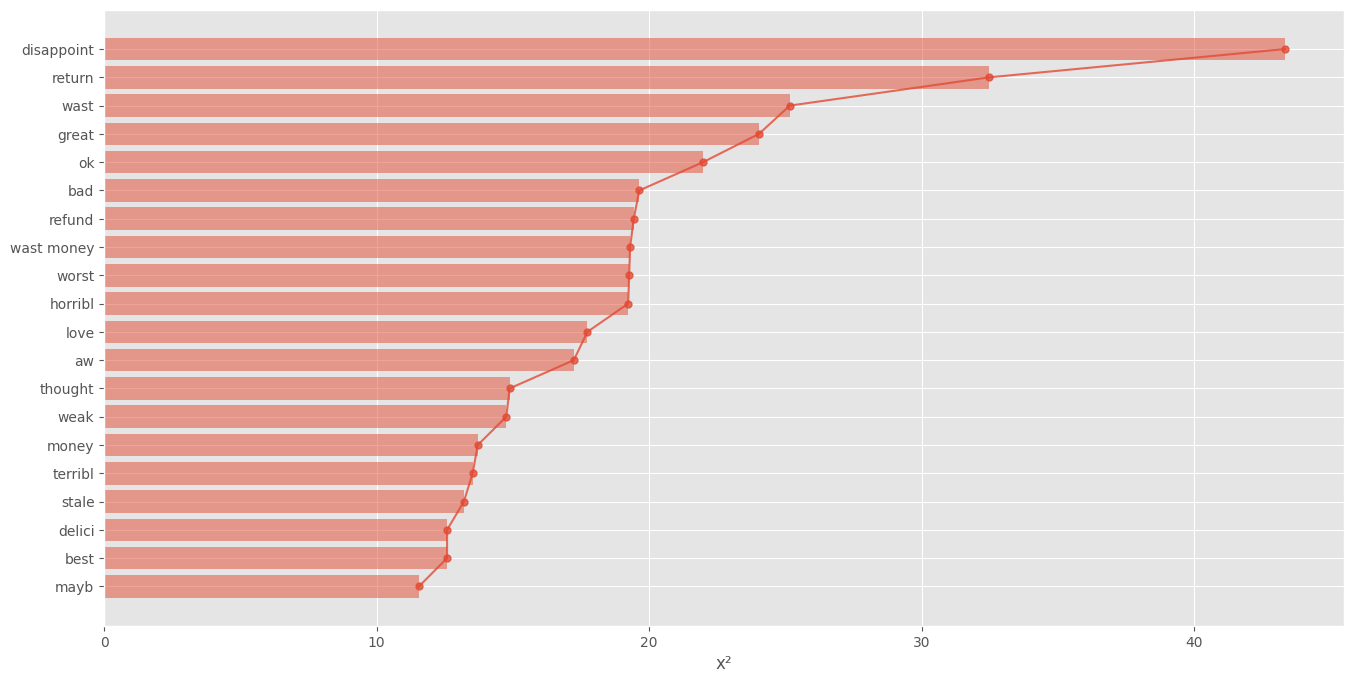

In [ ]:
plt.figure(figsize=(16,8))
# Use get_feature_names_out instead of get_feature_names
scores = list(zip(tfidf.get_feature_names_out(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('x²')
plt.show();

**LSTM Neural Network**

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical  # Update import path
from tensorflow.keras.layers import SpatialDropout1D  # Update import path
import re

In [ ]:
#30
max_fatures = 30000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(result['Reviews'].values)
X1 = tokenizer.texts_to_sequences(result['Reviews'].values)
X1 = pad_sequences(X1)


In [ ]:
#31
Y1 = pd.get_dummies(result['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(7500, 932) (7500, 2)
(2500, 932) (2500, 2)


**Embedding Layer**

In [ ]:
#32
embed_dim = 100
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#33
batch_size = 32
model.fit(X1_train, Y1_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
235/235 - 724s - 3s/step - accuracy: 0.7991 - loss: 0.4474
Epoch 2/10
235/235 - 681s - 3s/step - accuracy: 0.8779 - loss: 0.2942
Epoch 3/10
235/235 - 645s - 3s/step - accuracy: 0.9187 - loss: 0.2052
Epoch 4/10
235/235 - 703s - 3s/step - accuracy: 0.9481 - loss: 0.1454
Epoch 5/10
235/235 - 687s - 3s/step - accuracy: 0.9620 - loss: 0.1036
Epoch 6/10
235/235 - 671s - 3s/step - accuracy: 0.9720 - loss: 0.0793
Epoch 7/10
235/235 - 671s - 3s/step - accuracy: 0.9789 - loss: 0.0579
Epoch 8/10
235/235 - 693s - 3s/step - accuracy: 0.9835 - loss: 0.0466
Epoch 9/10
235/235 - 684s - 3s/step - accuracy: 0.9848 - loss: 0.0402
Epoch 10/10
235/235 - 668s - 3s/step - accuracy: 0.9885 - loss: 0.0327


In [ ]:
#34
score,acc = model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

79/79 - 58s - 739ms/step - accuracy: 0.8336 - loss: 0.8606
score: 0.86
acc: 0.83


In [ ]:
#35
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):

    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 0)[0]

    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 90.09483667017913 %
neg_acc 62.12624584717608 %
